# hw11: the adventure of the 2001 dimensions
**Sean's answers**

I have [w11-data.tbl](w11-data.tbl) as a file in my working directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

First let's get the data. I'll use pandas, since I haven't been using it enough.

In [2]:
data = pd.read_table('w11-data.tbl', delim_whitespace=True)
X    = np.log(np.add(1, data.to_numpy()))   # log counts, avoiding log(0) => log(x+1) transform of the original data.
n,p  = X.shape
n,p

(200, 2001)

Each row is a set of RNA-seq mapped counts for one cell, so the $n$ rows are our points. Each column is a gene; the $p$ genes are our $p$ coordinates (dimensions) for each point.

I've transformed the input count data to log(count + 1). The +1 is a common hack to avoid log(0). Doing k-means in log space makes more sense for RNA-seq data (as we saw in w05) because the counts are roughly lognormally distributed - much more so than they're normally distributed, anyway. 

## 1. reproduce Watson's K-means result.

Pulling in my verbose k-means implementation from week05. I've already transformed the count data to log space (log(x+1)) above. It's compute intensive -- precomputing the log() transformation speeds up the calculation some, but still, this takes a while. I'm just going to run 20 runs.

In [3]:
def sample_component(X):
    """
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
   
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.random.uniform(dmin[g], dmax[g])
    return mu

def euclidean_dist(v1, v2):
    """
    Return the euclidean distance || v1 - v2 ||.
    If do_logspace_distance is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        d += (v1[i] - v2[i])**2
    return np.sqrt(d)

def closest_centroid(x, centroids):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist

def assign_kmeans(X, centroids):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       totdist is the total distance 
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist

def update_kmeans(X, assignments, K):
    """
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = sample_component(X)                 # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts

def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

def kmeans(X, K):
    """
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
  
    centroids = np.zeros((K,G))
    for k in range(K):
        centroids[k] = sample_component(X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1

    kp = np.zeros(Q)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist


... and then run it...

In [4]:
Q = 8
for run in range(20):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(X, Q)
    if run == 0 or tot_sqdist < bestdist:
        bestdist = tot_sqdist
        bestrun  = run
    print("RNG seed {0:2d}:  tot_sqdist {1:12.1f}".format(run, tot_sqdist))

print("best run = {}".format(bestrun))
np.random.seed(bestrun)
kp, centroids, assignments, tot_sqdist = kmeans(X, Q)

RNG seed  0:  tot_sqdist      88340.6
RNG seed  1:  tot_sqdist      88107.9
RNG seed  2:  tot_sqdist      88397.8
RNG seed  3:  tot_sqdist      88118.8
RNG seed  4:  tot_sqdist      88631.3
RNG seed  5:  tot_sqdist      88946.9
RNG seed  6:  tot_sqdist      87699.9
RNG seed  7:  tot_sqdist      88019.8
RNG seed  8:  tot_sqdist      89634.8
RNG seed  9:  tot_sqdist      88476.6
RNG seed 10:  tot_sqdist      88795.2
RNG seed 11:  tot_sqdist      89428.5
RNG seed 12:  tot_sqdist      88476.8
RNG seed 13:  tot_sqdist      88573.3
RNG seed 14:  tot_sqdist      89002.2
RNG seed 15:  tot_sqdist      87856.9
RNG seed 16:  tot_sqdist      87378.2
RNG seed 17:  tot_sqdist      88661.9
RNG seed 18:  tot_sqdist      87893.6
RNG seed 19:  tot_sqdist      87606.4
best run = 16


Now `assignments[i]` is a (bad, as it turns out) cluster assignment, 0..7, for each cell $i$.

## 2. reduce the dimensionality

We'll do PCA by hand, using SVD. (Below, we'll also do it by eigendecomposition.) 

When I first did this, I got _completely_ jammed up for a while because I was doing the PCA in the original counts data, not log-transformed counts. Common sense tells us we should be doing it in log-counts, plus Tim Dunn (who wrote the pset originally) left us two clues. Common sense: we already know from our k-means experience that it's better to look at RNA-seq count data in log space, if we're going to use methods that assume Gaussian-distributed residuals and PCA (buried in its hidden little statistical heart) is a regression method that assumes Gaussian residuals. The two clues: first, Tim's heatmap was in units of log counts; second, his [simulated negative control eigenvalues](http://mcb112.org/w12/w12-eigen.tbl) are ludicrously, maddeningly nonsensical if you're comparing them to eigenvalues that have been calculated from count data.

Anyway. Once I'd figured _that_ out...

First we center (mean-subtract) in each dimension. Then we decompose the $n \times p$ centered matrix $\mathbf{X}^*$ using singular value decomposition, into $ \mathbf{U}  \mathbf{S}  \mathbf{W}^\top$. Numpy conveniently orders rows by their eigenvalues. To get the projection of our data onto the first two principal axes, we can either do $\mathbf{U}_q \mathbf{S}_q$ or we can do $\mathbf{X}^* \mathbf{W}_q$, where $\mathbf{U}_q$ and $\mathbf{W}_q$ are the leading $q$ (i.e., 2) columns of the $\mathbf{U}$ and $\mathbf{W}$ matrices. 

In [5]:
Xc       = X - np.mean(X, axis=0)                  # best way to think about axis=0 argument semantics is "collapse along axis=0 (rows)"
U, S, Wt = np.linalg.svd(Xc)
W        = np.transpose(Wt)
eigvals  = [ S[i]*S[i] / (n-1) for i in range(n)]
X2       = (Xc @ W)[:,:2]                          # X2 is now our data, n x 2, projected onto the first two PCs.
print(Xc.shape)
print(U.shape)
print(S.shape)
print(W.shape)
print(X2.shape)

(200, 2001)
(200, 200)
(200,)
(2001, 2001)
(200, 2)


Text(0, 0.5, 'PC2')

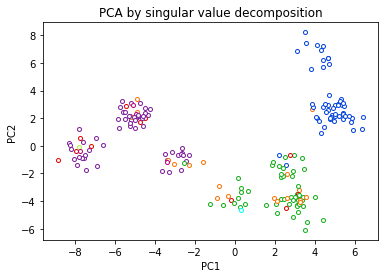

In [6]:
# I carefully chose a set of 16 colors, and their order, to
# give good visual discrimination of lots of clusters.
# I started with a list from here:
#    https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
#
Color = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]


fig1, ax1 = plt.subplots()
for i in range(n):
    ax1.plot(X2[i,0], X2[i,1], 'o', markersize=4, mfc='4', mec=Color[assignments[i]%16])
ax1.set_title('PCA by singular value decomposition')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

Hey look! That sort of looks like 8 clusters! Can't tell you how happy I was to see that. (The PCA on untransformed counts data looked like a Rorschach figure.)

We can double check our SVD version by doing PCA the other way: by calculating the covariation matrix from the data matrix $\mathbf{X}$ and doing an eigendecomposition. So first compute the covariance matrix, $\mathbf{\Sigma}$. The default `numpy.cov` wants its input to have rows as variables (and columns as observations/points), but we have columns as variables, so set `rowvar=False`.

A covariance matrix is a symmetric matrix, so we can use `np.linalg.eigh` on it. This gives us the eigenvalues $\mathbf{\Lambda}$, and $\mathbf{W}$, whose columns are our eigenvectors. `np.linalg.eigh` sorts the eigenvalues in _ascending_ order, so now the biggest one is the _last_ one. 

Here we'll also check that the total variance in the original data is the sum of the eigenvalues.

In [7]:
Sigma  = np.cov(X, rowvar=False)
Lam, W = np.linalg.eigh(Sigma)
pc1 = X @ W[:,2000]
pc2 = X @ W[:,1999]

# The total variance in the data = sum of variance in each gene i = sum down diagonal of the covariance mx
# The sum of the eigenvalues is still the total variance.
print("total variance, original: {0:.2f}".format(np.trace(Sigma)))
print("total variance, eigen:    {0:.2f}".format(np.sum(Lam)))

total variance, original: 475.40
total variance, eigen:    475.40


Text(0, 0.5, 'PC2')

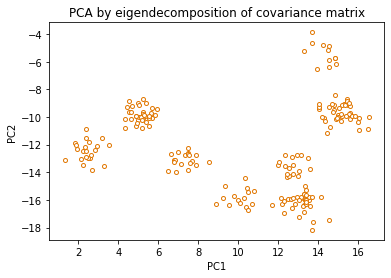

In [8]:
fig2, ax2 = plt.subplots()
ax2.plot(pc1,pc2, 'o', markersize=4, mfc='w', mec='xkcd:pumpkin')
ax2.set_title('PCA by eigendecomposition of covariance matrix')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

Yup, that's the same. (Up to scaling of the axes, anyway, because I projected the original data $\mathbf{X}$ here versus projecting the centered data $\mathbf{X}^*$ up above, and I didn't bother to color points by their bad k-means assignments either.)

Let's go back to our SVD solution, and plot the eigenvalues for each component:

[20.713307194973154, 9.593578360991541]


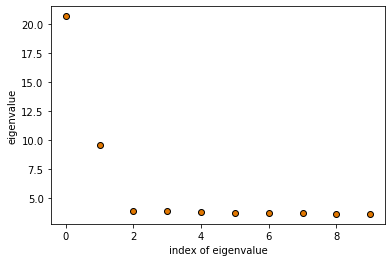

In [9]:
fig3, ax3 = plt.subplots()
ax3.plot(range(10), eigvals[:10], 'o', mfc='xkcd:pumpkin', mec='k')
ax3.set_xlabel('index of eigenvalue')
ax3.set_ylabel('eigenvalue')
print(eigvals[0:2])

Peeking into Tim's [simulated negative control eigenvalues](http://mcb112.org/w11/w11-eigen.tbl) shows us that the random distribution goes up to 3.8. We only have two eigenvalues that are well distinguished from that (20.7, 9.6). That's evidence that the first 2 PCs are capturing something "real", and the rest are noise. (How do we know what "noise" is, though? We're trusting Tim's negative control!)

**How many genes appear to influence cell type identity?** 

The "loading" is a projection of each gene by itself onto the PC space (i.e. simply the eigenvectors themselves!). If we only do the first 2 PCs, we can visualize the loadings as 2D vectors:

Text(0, 0.5, 'PC2')

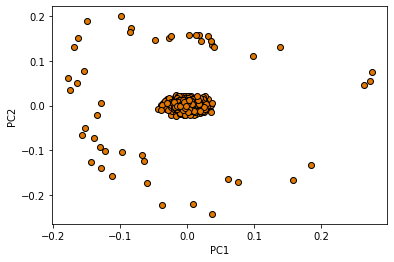

In [10]:
G2 = W[:,1999:2001] 
fig4, ax4 = plt.subplots()
ax4.plot(G2[:,0], G2[:,1], 'o', mfc='xkcd:pumpkin', mec='k')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')

That shows us that there are tens of genes that are important, with the rest of them in a massive cluster around the origin 0,0. There's a lot of spurious noise coming from lots of genes; we really just want to focus on those first 2 PCs where the real action is. 

Even more precisely, we can calculate the total variance accounted for by each _gene_ in just the first two PCs, to see (quantitatively) which genes are most important. Because each eigenvector is a unit vector of length 1, the _square_ of each individual element $j$ (components of the vector for each gene) is the proportion of the total variance along that eigenvector that gene $j$ accounts for. Then since $\lambda_i$ is the total variance along eigenvector $i$, $w_{ij}^2 \lambda_i$ is the variance for just gene $j$ along eigenvector $i$. Then $\sum_i w_{ij}^2 \lambda_i$ over our chosen set of principal axes $i$ gives us the total variance accounted for by gene $j$ in that set. Let's calculate that, for each gene:


In [11]:
Gsum = np.sum(np.square(G2) @ np.diag(eigvals[0:2]), axis=1)

Let's plot that:

Text(0, 0.5, 'variance')

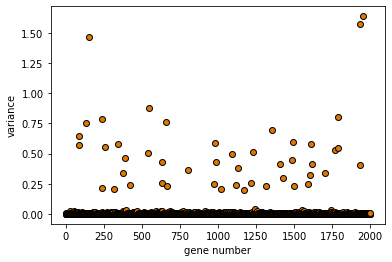

In [12]:
fig5, ax5 = plt.subplots()
ax5.plot(Gsum,'o',mfc='xkcd:pumpkin', mec='k')
ax5.set_xlabel('gene number')
ax5.set_ylabel('variance')

There's a clear break. Call it 0.1 or so. Let's pull out all the genes that contribute a total variance of 0.1 or more in the first two principal axes:

In [13]:
big_genes = [ g for g in range(p) if Gsum[g] > 0.1]
len(big_genes)

47

Looks like there's about 47 genes contributing to the 8 clusters of cell types.

## Check the K

Let's plot those bad k-means assignments again, just to admire how truly bad they are.

Text(0, 0.5, 'PC2')

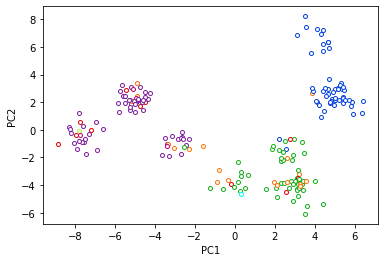

In [14]:
fig6, ax6 = plt.subplots()
for i in range(n):
    ax6.plot(X2[i,0], X2[i,1], 'o', markersize=4, mfc='w', mec=Color[assignments[i]%16])
ax6.set_xlabel('PC1')
ax6.set_ylabel('PC2')


The k-means assignments (the different colors) don't match the clusters we're seeing visually. A possible explanation: we've seen that the original data were really noisy. (We can see that in the heat map in the homework, for example.) Maybe the data are so noisy in various gene dimensions (~2000 of them!) that k-means can't see these 8 clusters as distinct; they're all overlapped in high dimensions, and k-means is only seeing 3-ish of them.

To address this, we can do k-means in the lower-dimensional PCA space, specifically our 2D space, `X2[]`.

In [15]:
Q = 8
for run2 in range(20):
    np.random.seed(run2)
    kp2, centroids2, assignments2, tot_sqdist2 = kmeans(X2, Q)
    if run2 == 0 or tot_sqdist2 < bestdist2:
        bestdist2 = tot_sqdist2
        bestrun2  = run2
    print("RNG seed {0:2d}:  tot_sqdist {1:12.1f}".format(run2, tot_sqdist2))

print("best run = {}".format(bestrun2))
np.random.seed(bestrun2)
kp2, centroids2, assignments2, tot_sqdist2 = kmeans(X2, Q)

RNG seed  0:  tot_sqdist        210.9
RNG seed  1:  tot_sqdist        129.7
RNG seed  2:  tot_sqdist        208.8
RNG seed  3:  tot_sqdist        302.1
RNG seed  4:  tot_sqdist        215.5
RNG seed  5:  tot_sqdist        300.9
RNG seed  6:  tot_sqdist        221.6
RNG seed  7:  tot_sqdist        220.0
RNG seed  8:  tot_sqdist        291.9
RNG seed  9:  tot_sqdist        205.6
RNG seed 10:  tot_sqdist        215.5
RNG seed 11:  tot_sqdist        208.6
RNG seed 12:  tot_sqdist        304.7
RNG seed 13:  tot_sqdist        294.7
RNG seed 14:  tot_sqdist        129.7
RNG seed 15:  tot_sqdist        219.2
RNG seed 16:  tot_sqdist        205.9
RNG seed 17:  tot_sqdist        221.2
RNG seed 18:  tot_sqdist        129.7
RNG seed 19:  tot_sqdist        295.7
best run = 1


Runs a heck of a lot faster in 2D than in 2001 dimensions, too!

Text(0, 0.5, 'PC2')

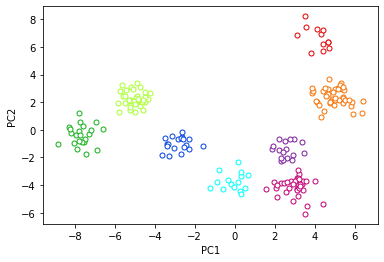

In [16]:
fig7, ax7 = plt.subplots()
for i in range(n):
    ax7.plot(X2[i,0], X2[i,1], 'o', markersize=5, mfc='w', mec=Color[assignments2[i]%16])
ax7.set_xlabel('PC1')
ax7.set_ylabel('PC2')

Well would you look at that.

## 4. reconstruct the expression patterns

To reconstruct the data using just the first two principal components, we're going to multiply $ \mathbf{U} \mathbf{S} \mathbf{W}^\top$ together, while only using the first two columns of $\mathbf{U}$ (making it $n \times 2$), the first two singular values in $S$ (and making it a diagonal 2x2 matrix) and the first two rows of $\mathbf{W}^\top$ (making it $2 \times p$). We get an $n \times p$ result.

Then we can downsample its columns, to look only at the 47 "big" genes we decided were most important.

And we can sort the rows (cells) in order of their k-means cluster assignments.

In [17]:
sorted_types = []
for q in range(8):
    for j in range(n):
        if assignments2[j] == q:
            sorted_types.append(j)

Dr = U[:,:2] @ np.diag(S[:2]) @ Wt[:2,:]
Dr_big = Dr[:,big_genes]
Dr_sort = Dr_big[sorted_types,:]

Text(0, 0.5, 'cells, clustered by k-means')

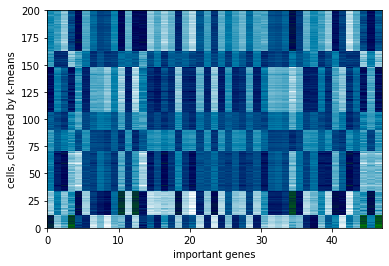

In [18]:
fig8, ax8 = plt.subplots()
ax8.pcolor(Dr_sort, cmap=plt.get_cmap("ocean_r"))
ax8.set_xlim(0,len(big_genes))
ax8.set_xlabel('important genes')
ax8.set_ylabel('cells, clustered by k-means')

Indeed, the clusters are obvious now!